In [1]:
from datasets import load_dataset
from utils import Evaluator
from transformers import AutoTokenizer

/Users/pietroferrazzi/Desktop/dottorato/LS-LLaMA-E3C/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### LOAD BEST MODEL RESULTS

In [2]:
checkpoint = "ferrazzipietro/LS_Llama-2-7b-hf_adapters_en.layer1_NoQuant_64_64_0.01_2_0.0002_3EpochsLast"# "ferrazzipietro/LS_Llama-2-7b-hf_adapters_en.layer1_NoQuant_16_32_0.05_2_0.0002_3EpochsLast"
data = load_dataset(checkpoint, split="test")
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
eval = Evaluator(data, tokenizer)
eval.extract_FP_FN_TP_TN_token_by_token()
print(eval.data)
eval.create_evaluation_table()
print(eval.evaluation_table)

/Users/pietroferrazzi/Desktop/dottorato/LS-LLaMA-E3C/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Map: 100%|██████████| 681/681 [00:00<00:00, 11997.32 examples/s]


Dataset({
    features: ['sentence', 'entities', 'original_text', 'original_id', 'tokens', 'ner_tags', 'input_ids', 'attention_mask', 'labels', 'predictions', 'ground_truth_labels', 'TP', 'FP', 'FN', 'TN', 'precision', 'recall', 'f1'],
    num_rows: 681
})
{'TP': 8596, 'FP': 2477, 'FN': 2270, 'precision': 0.7763027183238508, 'recall': 0.7910914780047855, 'f1': 0.7836273303249921}


In [3]:
eval.data.push_to_hub("ferrazzipietro/bestResults_LS_Llama-2-7b-hf_adapters_en.layer1_NoQuant_16_32_0.05_2_0.0002_3EpochsLast_eval")

Uploading the dataset shards: 100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/ferrazzipietro/bestResults_LS_Llama-2-7b-hf_adapters_en.layer1_NoQuant_16_32_0.05_2_0.0002_3EpochsLast_eval/commit/ca4a1204c2eea228f982e432e67f25692e7850f9', commit_message='Upload dataset', commit_description='', oid='ca4a1204c2eea228f982e432e67f25692e7850f9', pr_url=None, pr_revision=None, pr_num=None)

##### Questo mostra che avere frasi con parole composte da tanti token non peggiora le performances: f1 solo sulle frasi con almeno una parola composta da almeno 6 token è praticamente uguale a quella complessiva

In [19]:
err_analist = ErrorAnalyst(eval.data, tokenizer)


Dataset({
    features: ['sentence', 'entities', 'original_text', 'original_id', 'tokens', 'ner_tags', 'input_ids', 'attention_mask', 'labels', 'predictions', 'ground_truth_labels', 'TP', 'FP', 'FN', 'TN', 'precision', 'recall', 'f1', 'multitoken_words', 'interesting_token_mask'],
    num_rows: 177
})

In [6]:
data_with_multitoken_worsd_4 = err_analist.get_sentences_with_multitoken_words(6, 100)
eval_with_multitoken_worsd_4 = Evaluator(data_with_multitoken_worsd_4, tokenizer)
eval_with_multitoken_worsd_4.extract_FP_FN_TP_TN_token_by_token()
print("WITH:    ", eval_with_multitoken_worsd_4.create_evaluation_table())

data_without_multitoken_worsd_4 = err_analist.get_sentences_with_multitoken_words(0, 5)
eval_without_multitoken_worsd_4 = Evaluator(data_without_multitoken_worsd_4, tokenizer)
eval_without_multitoken_worsd_4.extract_FP_FN_TP_TN_token_by_token()
print("WITHOUT: ", eval_without_multitoken_worsd_4.create_evaluation_table())

Map: 100%|██████████| 177/177 [00:00<00:00, 5214.63 examples/s]


WITH:     {'TP': 3174, 'FP': 851, 'FN': 900, 'precision': 0.7885714285714286, 'recall': 0.7790868924889544, 'f1': 0.7838004691937277}


Map: 100%|██████████| 681/681 [00:00<00:00, 8791.76 examples/s]


WITHOUT:  {'TP': 8596, 'FP': 2477, 'FN': 2270, 'precision': 0.7763027183238508, 'recall': 0.7910914780047855, 'f1': 0.7836273303249921}


##### vediamo se le parole stesse composte da molti token (e non le frasi intere, ma solo e soltanto le parole) sono missclassificate. La risposta è: NO, anzi. Le parole lunghe sono ben assegante

In [7]:
data_with_multitoken_worsd_6 = err_analist.get_multitokens_words(6, 100)
eval_with_multitoken_worsd_6 = Evaluator(data_with_multitoken_worsd_6, tokenizer)
eval_with_multitoken_worsd_6.extract_FP_FN_TP_TN_token_by_token()
eval_with_multitoken_worsd_6.create_evaluation_table()

Map: 100%|██████████| 177/177 [00:00<00:00, 13050.29 examples/s]


{'TP': 967,
 'FP': 132,
 'FN': 195,
 'precision': 0.8798908098271155,
 'recall': 0.8321858864027539,
 'f1': 0.855373728438744}

##### ci sono 2 tipi di parole lunghe: quelle composte da numeri e quelle che sono vere e proprie parole. Qui si vede che le parole vere r e proprie hanno performances peggiori (molto) di quelle che contengono numeri. La parte di interesse è quindi dire che i numeri lunghi vengono classificati molto bene, le parole lunghe nella media.

In [8]:
data_with_multitoken_worsd_6 = err_analist.get_multitokens_words_with_numbers(6, 100)
eval_with_multitoken_worsd_6 = Evaluator(data_with_multitoken_worsd_6, tokenizer)
eval_with_multitoken_worsd_6.extract_FP_FN_TP_TN_token_by_token()
print("many tokens containing numbers: ",eval_with_multitoken_worsd_6.create_evaluation_table())
      
data_with_multitoken_worsd_6 = err_analist.get_multitokens_words_without_numbers(6, 100)
eval_with_multitoken_worsd_6 = Evaluator(data_with_multitoken_worsd_6, tokenizer)
eval_with_multitoken_worsd_6.extract_FP_FN_TP_TN_token_by_token()
print("many tokens NOT containing numbers: ",eval_with_multitoken_worsd_6.create_evaluation_table())

Map: 100%|██████████| 86/86 [00:00<00:00, 7514.95 examples/s]


many tokens containing numbers:  {'TP': 651, 'FP': 39, 'FN': 101, 'precision': 0.9434782608695652, 'recall': 0.8656914893617021, 'f1': 0.9029126213592233}


Map: 100%|██████████| 91/91 [00:00<00:00, 9051.24 examples/s]

many tokens NOT containing numbers:  {'TP': 316, 'FP': 93, 'FN': 94, 'precision': 0.7726161369193154, 'recall': 0.7707317073170732, 'f1': 0.7716727716727716}


In [9]:
print(data_with_multitoken_worsd_6['sentence'][:10])

['atrioventricular', 'hemoperitoneum.', 'anti-tuberculosis', 'lobo-isthmectomy,', 'Transthoracic', 'chondromatosis)', 'Antero-posterior', 'μg/L; μg/L;', 'Lymphadenopathy', 'non-contributory.']


##### vediamo come vanno le performances dato il numero di token da cui le parole sono composte. Si vede che il modello assegna bene parole lunghe, ma male parole corte

Map: 100%|██████████| 681/681 [00:00<00:00, 15565.70 examples/s]


Threshold: 0 {'TP': 1517, 'FP': 438, 'FN': 692, 'precision': 0.7759590792838875, 'recall': 0.6867360796740607, 'f1': 0.7286263208453411}


Map: 100%|██████████| 680/680 [00:00<00:00, 15495.72 examples/s]


Threshold: 1 {'TP': 3527, 'FP': 1130, 'FN': 1035, 'precision': 0.757354520077303, 'recall': 0.7731258220078913, 'f1': 0.7651589109447879}


Map: 100%|██████████| 669/669 [00:00<00:00, 15874.12 examples/s]


Threshold: 2 {'TP': 4064, 'FP': 1291, 'FN': 757, 'precision': 0.7589169000933706, 'recall': 0.8429786351379381, 'f1': 0.7987421383647798}


Map: 100%|██████████| 612/612 [00:00<00:00, 15534.18 examples/s]


Threshold: 3 {'TP': 3307, 'FP': 987, 'FN': 817, 'precision': 0.7701443875174663, 'recall': 0.8018913676042677, 'f1': 0.7856973152767879}


Map: 100%|██████████| 449/449 [00:00<00:00, 5843.32 examples/s]


Threshold: 4 {'TP': 2048, 'FP': 616, 'FN': 626, 'precision': 0.7687687687687688, 'recall': 0.7658937920718025, 'f1': 0.7673285874859497}


Map: 100%|██████████| 271/271 [00:00<00:00, 14068.23 examples/s]


Threshold: 5 {'TP': 1171, 'FP': 315, 'FN': 338, 'precision': 0.7880215343203231, 'recall': 0.7760106030483764, 'f1': 0.7819699499165276}


Map: 100%|██████████| 154/154 [00:00<00:00, 12998.27 examples/s]


Threshold: 6 {'TP': 664, 'FP': 112, 'FN': 149, 'precision': 0.8556701030927835, 'recall': 0.8167281672816729, 'f1': 0.8357457520453115}


Map: 100%|██████████| 82/82 [00:00<00:00, 9810.96 examples/s]


Threshold: 7 {'TP': 417, 'FP': 26, 'FN': 56, 'precision': 0.9413092550790068, 'recall': 0.8816067653276956, 'f1': 0.9104803493449781}


Map: 100%|██████████| 681/681 [00:00<00:00, 13900.25 examples/s]


Threshold: 0 {'TP': 1517, 'FP': 438, 'FN': 692, 'precision': 0.7759590792838875, 'recall': 0.6867360796740607, 'f1': 0.7286263208453411}


Map: 100%|██████████| 618/618 [00:00<00:00, 13262.38 examples/s]


Threshold: 1 {'TP': 3010, 'FP': 956, 'FN': 874, 'precision': 0.7589510842158346, 'recall': 0.7749742533470649, 'f1': 0.7668789808917199}


Map: 100%|██████████| 529/529 [00:00<00:00, 13183.52 examples/s]


Threshold: 2 {'TP': 2938, 'FP': 946, 'FN': 496, 'precision': 0.7564366632337796, 'recall': 0.8555620267909144, 'f1': 0.8029516261273572}


Map: 100%|██████████| 475/475 [00:00<00:00, 12989.19 examples/s]


Threshold: 3 {'TP': 2327, 'FP': 724, 'FN': 485, 'precision': 0.7627007538511963, 'recall': 0.827524893314367, 'f1': 0.7937915742793791}


Map: 100%|██████████| 356/356 [00:00<00:00, 8537.93 examples/s]


Threshold: 4 {'TP': 1428, 'FP': 415, 'FN': 372, 'precision': 0.7748236570808464, 'recall': 0.7933333333333333, 'f1': 0.7839692561076037}


Map: 100%|██████████| 191/191 [00:00<00:00, 10226.48 examples/s]


Threshold: 5 {'TP': 692, 'FP': 233, 'FN': 200, 'precision': 0.7481081081081081, 'recall': 0.7757847533632287, 'f1': 0.7616951018161805}


Map: 100%|██████████| 83/83 [00:00<00:00, 7945.57 examples/s]


Threshold: 6 {'TP': 241, 'FP': 84, 'FN': 79, 'precision': 0.7415384615384616, 'recall': 0.753125, 'f1': 0.7472868217054263}


Map: 100%|██████████| 39/39 [00:00<00:00, 2805.94 examples/s]


Threshold: 7 {'TP': 136, 'FP': 19, 'FN': 40, 'precision': 0.8774193548387097, 'recall': 0.7727272727272727, 'f1': 0.8217522658610271}


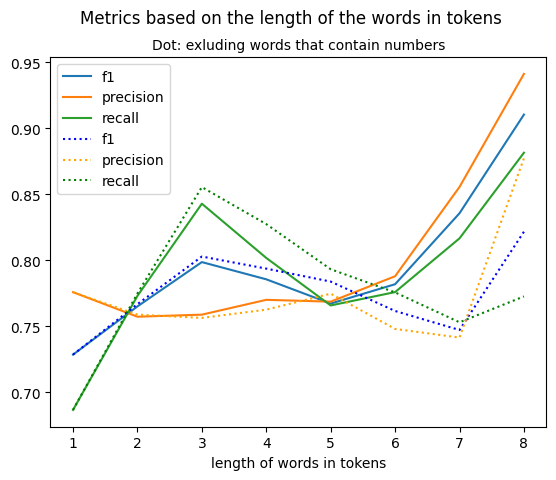

[681, 618, 529, 475, 356, 191, 83, 39]

In [10]:
f1 = []
precision = []
recall = []
n_tokens_threshold = []
n_rows = []
for threshold in range(8):
    data_tmp = err_analist.get_multitokens_words(threshold, threshold+1)
    eval_tmp = Evaluator(data_tmp, tokenizer)
    eval_tmp.extract_FP_FN_TP_TN_token_by_token()
    eval_tmp.create_evaluation_table()
    print(f"Threshold: {threshold}", eval_tmp.evaluation_table)
    n_tokens_threshold.append(threshold+1)
    f1.append(eval_tmp.evaluation_table['f1'])
    precision.append(eval_tmp.evaluation_table['precision'])
    recall.append(eval_tmp.evaluation_table['recall'])
    n_rows.append(len(data_tmp))

import matplotlib.pyplot as plt
plt.plot(n_tokens_threshold, f1, label='f1')
plt.plot(n_tokens_threshold, precision, label='precision')
plt.plot(n_tokens_threshold, recall, label='recall')
#plt.show()
n_rows

f1 = []
precision = []
recall = []
n_tokens_threshold = []
n_rows = []
for threshold in range(8):
    data_tmp = err_analist.get_multitokens_words_without_numbers(threshold, threshold+1)
    eval_tmp = Evaluator(data_tmp, tokenizer)
    eval_tmp.extract_FP_FN_TP_TN_token_by_token()
    eval_tmp.create_evaluation_table()
    print(f"Threshold: {threshold}", eval_tmp.evaluation_table)
    n_tokens_threshold.append(threshold+1)
    f1.append(eval_tmp.evaluation_table['f1'])
    precision.append(eval_tmp.evaluation_table['precision'])
    recall.append(eval_tmp.evaluation_table['recall'])
    n_rows.append(len(data_tmp))

import matplotlib.pyplot as plt
plt.plot(n_tokens_threshold, f1, label='f1',linestyle=':', color='blue')
plt.plot(n_tokens_threshold, precision, label='precision',linestyle=':', color='orange')
plt.plot(n_tokens_threshold, recall, label='recall',linestyle=':', color='green')
#plt.xlabel('length of words in tokens')
#plt.title('Metrics for NO NUMBERS based on the length of the words in tokens')
plt.xlabel('length of words in tokens')
plt.legend()
plt.suptitle('Metrics based on the length of the words in tokens')
plt.title('Dot: exluding words that contain numbers', fontsize=10)  # Main title

plt.legend()
plt.show()
n_rows


# f1 = []
# precision = []
# recall = []
# n_tokens_threshold = []
# n_rows = []
# for threshold in range(8):
#     try: 
#         data_tmp = err_analist.get_multitokens_words_with_numbers(threshold, threshold+1)
#         eval_tmp = Evaluator(data_tmp, tokenizer)
#         eval_tmp.extract_FP_FN_TP_TN_token_by_token()
#         eval_tmp.create_evaluation_table()
#         print(f"Threshold: {threshold}", eval_tmp.evaluation_table)
#         n_tokens_threshold.append(threshold+1)
#         f1.append(eval_tmp.evaluation_table['f1'])
#         precision.append(eval_tmp.evaluation_table['precision'])
#         recall.append(eval_tmp.evaluation_table['recall'])
#         n_rows.append(len(data_tmp))
#     except:
#         print(f"Threshold: {threshold} not possible")

# import matplotlib.pyplot as plt
# plt.plot(n_tokens_threshold, f1, label='f1',linestyle=':',)
# plt.plot(n_tokens_threshold, precision, label='precision',linestyle=':',)
# plt.plot(n_tokens_threshold, recall, label='recall', linestyle=':',)
# plt.xlabel('length of words in tokens')
# plt.title('Metrics for ONLY NUMBERS based on the length of the words in tokens')
# plt.legend()
# plt.show()
# n_rows



##### qui si vede la distribuzione della proporzione di TP, FN e FP per frase. I TP sono magari normali, gli altri qualcosa tipo gamma

Map: 100%|██████████| 681/681 [00:00<00:00, 7628.35 examples/s]


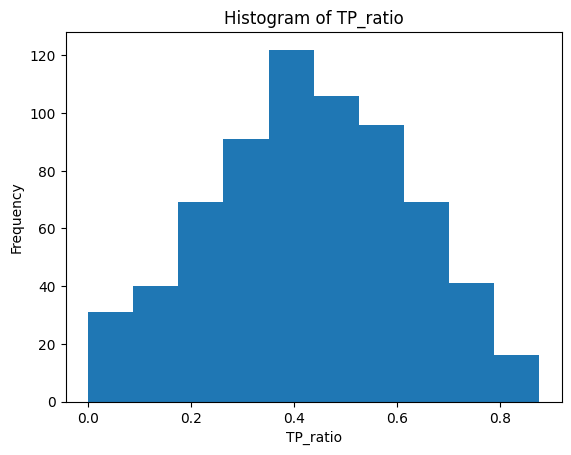

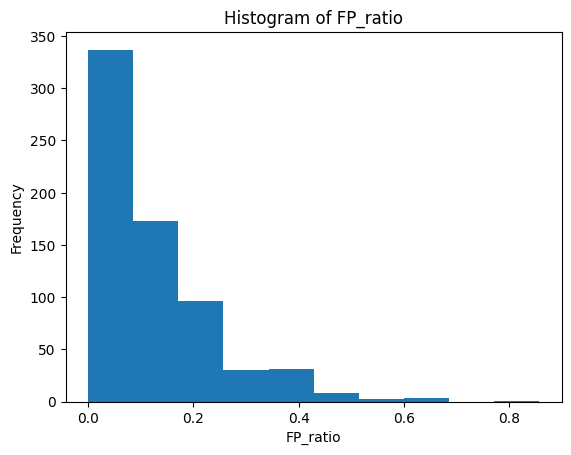

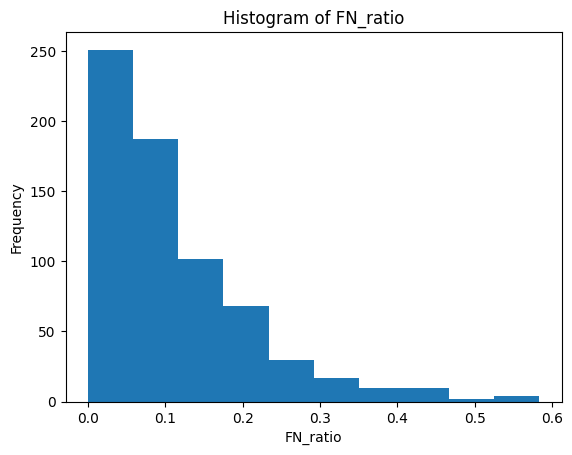

In [11]:
import matplotlib.pyplot as plt


def helper(example):
    example['TP_ratio'] = example['TP'] / len(example['predictions'])
    example['FP_ratio'] = example['FP'] / len(example['predictions'])
    example['FN_ratio'] = example['FN'] / len(example['predictions'])
    return example

tmp = eval.data.map(helper, batched=False)

plt.hist(tmp['TP_ratio'])
plt.xlabel('TP_ratio')
plt.ylabel('Frequency')
plt.title('Histogram of TP_ratio')
plt.show()

plt.hist(tmp['FP_ratio'])
plt.xlabel('FP_ratio')
plt.ylabel('Frequency')
plt.title('Histogram of FP_ratio')
plt.show()

plt.hist(tmp['FN_ratio'])
plt.xlabel('FN_ratio')
plt.ylabel('Frequency')
plt.title('Histogram of FN_ratio')
plt.show()

In [12]:
data_recLower30 = err_analist.get_examples_based_on_metric('recall', lower_threshold=0.05, upper_threshold=0.1)
err_analist.print_formatted_data(data_recLower30)

In [15]:
data_precLower30 = err_analist.get_examples_based_on_metric('precision', lower_threshold=0.05, upper_threshold=0.1)
err_analist.print_formatted_data(data_precLower30)

LUNGHEZZA: 17
The mass was firm, painless, and mobile with the swallowing movements.
[('▁The', 'O', 'O'), ('▁mass', 'B', 'B'), ('▁was', 'O', 'O'), ('▁firm', 'B', 'O'), (',', 'I', 'O'), ('▁pain', 'B', 'O'), ('less', 'I', 'O'), (',', 'I', 'O'), ('▁and', 'O', 'O'), ('▁mobile', 'B', 'O'), ('▁with', 'O', 'O'), ('▁the', 'O', 'O'), ('▁sw', 'I', 'O'), ('allow', 'I', 'O'), ('ing', 'I', 'O'), ('▁movements', 'B', 'O'), ('.', 'I', 'O')]


In [17]:
data_f1Lower30 = err_analist.get_examples_based_on_metric('f1', lower_threshold=0.05, upper_threshold=0.1)
err_analist.print_formatted_data(data_f1Lower30)

LUNGHEZZA: 48
The immunological tests such as antinuclear antibodies (ANA), anti-LKM1, anti-mitochondria and anti-smooth muscle antibodies were negatives.
[('▁The', 'O', 'O'), ('▁imm', 'O', 'O'), ('un', 'O', 'O'), ('ological', 'O', 'O'), ('▁tests', 'B', 'B'), ('▁such', 'O', 'O'), ('▁as', 'O', 'O'), ('▁ant', 'O', 'O'), ('in', 'O', 'O'), ('uc', 'O', 'O'), ('lear', 'O', 'O'), ('▁ant', 'O', 'O'), ('ib', 'I', 'O'), ('od', 'O', 'O'), ('ies', 'I', 'O'), ('▁(', 'B', 'O'), ('AN', 'I', 'O'), ('A', 'I', 'O'), ('),', 'I', 'O'), ('▁anti', 'O', 'O'), ('-', 'I', 'O'), ('L', 'I', 'O'), ('K', 'I', 'O'), ('M', 'I', 'O'), ('1', 'O', 'O'), (',', 'O', 'O'), ('▁anti', 'O', 'O'), ('-', 'O', 'O'), ('m', 'O', 'O'), ('ito', 'O', 'O'), ('ch', 'I', 'O'), ('ond', 'O', 'O'), ('ria', 'O', 'O'), ('▁and', 'O', 'O'), ('▁anti', 'O', 'O'), ('-', 'O', 'O'), ('sm', 'O', 'O'), ('ooth', 'O', 'O'), ('▁mus', 'I', 'O'), ('cle', 'I', 'O'), ('▁ant', 'I', 'O'), ('ib', 'I', 'O'), ('od', 'I', 'O'), ('ies', 'I', 'O'), ('▁were', 'O', 

In [18]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
eval = Evaluator(data, tokenizer)
eval.extract_FP_FN_TP_TN_token_by_token()
res_IO = err_analist.search_OI(verbose=False)
print(f"there are {res_IO['n_OI_occurences']} OI occurences in {res_IO['n_impacted_sentences']} sentences.\n the total number of tokens is {res_IO['tot_tokens']} -> {round(res_IO['n_OI_occurences']/res_IO['tot_tokens']*100,1)}% of the tokens are OI")

/Users/pietroferrazzi/Desktop/dottorato/LS-LLaMA-E3C/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


there are 1548 OI occurences in 582 sentences.
 the total number of tokens is 20526 -> 7.5% of the tokens are OI


In [109]:
import re
import pandas as pd
from datasets import Dataset
    
class ErrorAnalyst():

    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

    def get_examples_based_on_metric(self, metric, upper_threshold=1, lower_threshold=0):
        """
        Select the examples based on the metric and the threshold.
        Args:
        metric (str): the metric to consider
        threshold (float): the threshold to consider
        return:
        list: the list of examples that satisfy the condition
        """
        out = [example for example in self.data if example[metric] <= upper_threshold and example[metric] >= lower_threshold]
        return(Dataset.from_pandas(pd.DataFrame(out)))
    
    def print_formatted_data(self, data):
        """
        Print the data in a human readable format.
        """
        for example in data:
            sentence_pred = example['predictions']
            sentence = example['sentence']
            tokenized_input = self.tokenizer(sentence, add_special_tokens=False)
            tokens = self.tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
            print("LUNGHEZZA:", len(tokens))
            print(f"{sentence}\n{[(t,p, ground_truth_label) for t, p, ground_truth_label in zip(tokens, sentence_pred, example['ground_truth_labels'])]}")

    def search_OI(self, verbose):
        """
        """
        counter = 0
        tot_tokens = 0
        if verbose: print('(token, prediction, ground_truth_label)')
        self.disallined_df = pd.DataFrame(columns=['id', 'token', 'prediction', 'ground_truth_label'])
        id_sentence = 0
        for example in self.data:
            sentence_pred = example['predictions']
            sentence = example['sentence']
            previous = '' 
            appened = False
            for token in sentence_pred:
                if token=='I' and previous=='O':
                    appened = True
                    counter+=1
                    # print('token:', token, 'previous:', previous, 'position:', i, 'sentence:', sentence_pred)
                previous = token
                tot_tokens += 1
            if appened:
                tokenized_input = self.tokenizer(sentence, add_special_tokens=False)
                tokens = self.tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
                self.disallined_df = pd.concat([self.disallined_df, pd.DataFrame([{'id': id_sentence,'token':t, 'prediction': p, 'ground_truth_label': ground_truth_label} for t, p, ground_truth_label in zip(tokens, sentence_pred, example['ground_truth_labels'])])])
                if verbose: print([(t,p, ground_truth_label) for t, p, ground_truth_label in zip(tokens, sentence_pred, example['ground_truth_labels'])])
                id_sentence += 1
        return {'n_OI_occurences':counter, 'tot_tokens':tot_tokens, 'n_impacted_sentences': id_sentence}
    
    def split_sentence_into_tokens(self, sentence):
        """
        """
        tokenized_input = self.tokenizer(sentence, add_special_tokens=False)
        tokens = self.tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
        return(tokens)

    def _extract_multitoken_words_from_example(self, example, n_tokens_threshold_lower, n_tokens_threshold_upper):
        """
        """
        sentence = example['sentence']
        tokens = self.split_sentence_into_tokens(sentence)
        multitoken_words = []
        multitoken_word = ''
        token_counter = 0
        interesting_token_mask = [0]*len(tokens)
        for i, token in enumerate(tokens):
            if token.startswith('▁'):
                if token_counter >= n_tokens_threshold_lower and token_counter <= n_tokens_threshold_upper:
                    multitoken_words.append(multitoken_word)
                    interesting_token_mask[i-token_counter:i] = [1]*token_counter
                multitoken_word = token[1:]
                token_counter = 1
            else:
                multitoken_word += token
                token_counter += 1

        if token_counter >= n_tokens_threshold_lower and token_counter <= n_tokens_threshold_upper:
            multitoken_words.append(multitoken_word)
            interesting_token_mask[-token_counter:] = [1]*token_counter
        example[f'multitoken_words'] = multitoken_words
        example[f'interesting_token_mask'] = interesting_token_mask
        return example

    def get_sentences_with_multitoken_words(self, n_tokens_threshold_lower, n_tokens_threshold_upper):
        """
        """
        out = self.data.map(lambda example: self._extract_multitoken_words_from_example(example, n_tokens_threshold_lower, n_tokens_threshold_upper))
        out = out.filter(lambda example: len(example[f'multitoken_words'])>0)
        return out

    # def get_sentences_without_multitoken_words(self, n_tokens_threshold):
    #     """
    #     """
    #     out = self.data.map(lambda example: self._extract_multitoken_words_from_example(example, n_tokens_threshold))
    #     out = out.filter(lambda example: len(example[f'multitoken_words_{n_tokens_threshold}'])==0)
    #     return out
    
    def get_multitokens_words(self, n_tokens_threshold_lower, n_tokens_threshold_upper):
        """
        """
        out = self.get_sentences_with_multitoken_words( n_tokens_threshold_lower, n_tokens_threshold_upper)

        def helper(example):
            interesting_token_mask = example[f'interesting_token_mask']
            attention_mask = [bit for bit, mask in zip(example['attention_mask'], interesting_token_mask) if mask==1]
            labels = [bit for bit, mask in zip(example['labels'], interesting_token_mask) if mask==1]
            predictions = [bit for bit, mask in zip(example['predictions'], interesting_token_mask) if mask==1]
            ground_truth_labels = [bit for bit, mask in zip(example['ground_truth_labels'], interesting_token_mask) if mask==1]
            input_ids = [bit for bit, mask in zip(example['input_ids'], interesting_token_mask) if mask==1]
            sentence = tokenizer.decode(input_ids)
            new_example= {'sentence': sentence, 'attention_mask': attention_mask, 'input_ids': input_ids, 'labels': labels, 'predictions': predictions, 'ground_truth_labels': ground_truth_labels}
            return new_example
    
        out = out.map(helper, remove_columns=['TP', 'FP', 'FN', 'TN', 'precision', 'recall', 'f1', 'ner_tags', 'tokens', f'interesting_token_mask'])
        return out
    
    def get_multitokens_words_without_numbers(self, n_tokens_threshold_lower, n_tokens_threshold_upper):
        """
        """
        out = self.get_multitokens_words(n_tokens_threshold_lower, n_tokens_threshold_upper)
        out = out.filter(lambda example: not any(char.isdigit() for char in example['sentence']))
        return out
    
    def get_multitokens_words_with_numbers(self, n_tokens_threshold_lower, n_tokens_threshold_upper):
        """
        """
        out = self.get_multitokens_words(n_tokens_threshold_lower, n_tokens_threshold_upper)
        out = out.filter(lambda example: any(char.isdigit() for char in example['sentence']))
        return out
    
    def get_transition_matrix(self):
        """
        """
        def convert_to_probabilities(data):
            new_data = {}
            # Iterate over each outer key in the dictionary
            for key, subdict in data.items():
                new_data[key] = {}
                # Calculate the sum of the sub-dictionary values
                total = sum(subdict.values())
                # Normalize each value by dividing by the total sum
                for subkey in subdict:
                    new_data[key][subkey] = round(subdict[subkey] / total, 3)
            return new_data
        
        transition_matrix = {'O': {'O': 0, 'I': 0, 'B':0}, 
                             'I': {'O': 0, 'I': 0, 'B':0},
                             'B': {'O': 0, 'I': 0, 'B':0}}
        for example in self.data:
            previous = 'O'
            for token in example['predictions']:
                transition_matrix[previous][token] += 1
                previous = token

        self.transition_matrix = transition_matrix.copy()
        probability_matrix = convert_to_probabilities(transition_matrix)
        self.probability_matrix = probability_matrix.copy()

err_analist = ErrorAnalyst(eval.data, tokenizer)


#### Here is the transition matrix:

In [111]:
err_analist.get_transition_matrix()
#err_analist.transition_matrix

display(err_analist.probability_matrix)
err_analist.transition_matrix

{'O': {'O': 0.664, 'I': 0.154, 'B': 0.183},
 'I': {'O': 0.238, 'I': 0.693, 'B': 0.069},
 'B': {'O': 0.346, 'I': 0.567, 'B': 0.088}}

{'O': {'O': 6683, 'I': 1548, 'B': 1840},
 'I': {'O': 1867, 'I': 5432, 'B': 544},
 'B': {'O': 903, 'I': 1480, 'B': 229}}

#### Here is the clinent only

In [10]:
len("ferrazzipietro/LS_Llama-2-7b-hf_adapters_en.layer1_NoQuant_16_32_0.01_1_0.0002_6Epochs_clent_bf" )

95

In [16]:

from datasets import load_dataset
from utils import Evaluator
from transformers import AutoTokenizer
from dotenv import dotenv_values
from huggingface_hub import login 
HF_TOKEN = dotenv_values(".env.base")['HF_TOKEN']

login(token=HF_TOKEN)

checkpoint = "ferrazzipietro/LS_Llama-2-7b-hf_adapters_en.layer1_NoQuant_32_64_0.01_1_0.0002_6Epochs_clent_bf"
data = load_dataset(checkpoint, split='test')
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
eval = Evaluator(data, tokenizer)
eval.extract_FP_FN_TP_TN_token_by_token()
print(eval.data)
eval.create_evaluation_table()
print(eval.evaluation_table)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /Users/pietroferrazzi/.cache/huggingface/token
Login successful


/Users/pietroferrazzi/Desktop/dottorato/LS-LLaMA-E3C/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


OSError: ferrazzipietro/LS_Llama-2-7b-hf_adapters_en.layer1_NoQuant_32_64_0.01_1_0.0002_6Epochs_clent_bf is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

In [15]:
data['predictions']

[['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'O',
  'O',
  'O',
  '